In [55]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import shap
from statsbombpy import sb
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, confusion_matrix

pd.set_option('display.max_columns', 100)

In [56]:
sb.competitions().query("competition_name == 'La Liga'").sort_values("season_name", ascending=False).head(3)

credentials were not supplied. open data access only


,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
20,11,90,Spain,La Liga,male,False,False,2020/2021,2022-02-11T14:56:09.076,2022-08-16T21:50:36.812060,2022-08-16T21:50:36.812060,2022-02-11T14:56:09.076
21,11,42,Spain,La Liga,male,False,False,2019/2020,2022-07-15T23:27:24.260122,2021-06-13T16:17:31.694,None,2022-07-15T23:27:24.260122
22,11,4,Spain,La Liga,male,False,False,2018/2019,2022-08-30T23:25:57.118855,2021-07-09T14:53:22.103024,None,2022-08-30T23:25:57.118855


In [57]:
LALIGA_ID = 11
SEASON_2021_ID = 90 

In [58]:
all_matches = sb.matches(competition_id=LALIGA_ID, season_id=SEASON_2021_ID)
match_passes = pd.concat(
               [sb.events(match_id=match_id, split=True, flatten_attrs=False)["passes"]
               .assign(match_date = match_date)
               .assign(match_week = match_week) 
               .assign(home_team = home_team)
               .assign(away_team = away_team)
               for match_id, match_week, home_team, away_team, match_date 
               in zip(
                    all_matches["match_id"], all_matches["match_week"],
                    all_matches["home_team"], all_matches["away_team"],
                    all_matches["match_date"]
                     )
                ]
               )

credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data acces

In [59]:
print(f"Dataset with {len(match_passes):,} passes")
print(list(match_passes.columns))

Dataset with 40,337 passes
['id', 'index', 'period', 'timestamp', 'minute', 'second', 'type', 'possession', 'possession_team', 'play_pattern', 'team', 'player', 'position', 'location', 'duration', 'related_events', 'pass', 'match_id', 'possession_team_id', 'player_id', 'under_pressure', 'counterpress', 'off_camera', 'match_date', 'match_week', 'home_team', 'away_team', 'out']


In [60]:
match_passes.head(3)

,id,index,period,timestamp,minute,second,type,possession,possession_team,play_pattern,team,player,position,location,duration,related_events,pass,match_id,possession_team_id,player_id,under_pressure,counterpress,off_camera,match_date,match_week,home_team,away_team,out
0,3c824f32-fcd1-4191-b824-26bb32d9bd6c,5,1,00:00:00.992,0,0,Pass,2,Real Betis,From Kick Off,Real Betis,Borja Iglesias Quintas,Center Forward,"[60.0, 40.0]",1.137457,[953b857b-55b9-4f14-974c-63e2929e6de1],"{'recipient': {'id': 2948, 'name': 'Nabil Feki...",3773631,218,11391,NaN,NaN,NaN,2021-02-07,22,Real Betis,Barcelona,NaN
1,723a939c-cc2f-49a9-8b95-20373c926cc6,7,1,00:00:02.130,0,2,Pass,2,Real Betis,From Kick Off,Real Betis,Nabil Fekir,Center Attacking Midfield,"[56.7, 41.1]",1.100128,[59962ded-d646-4f9c-bf6d-ebba06ef28d3],"{'recipient': {'id': 42282, 'name': 'Paul Edga...",3773631,218,2948,NaN,NaN,NaN,2021-02-07,22,Real Betis,Barcelona,NaN
2,90973a59-4f2e-436c-a982-45a6fd35280d,10,1,00:00:04.345,0,4,Pass,2,Real Betis,From Kick Off,Real Betis,Paul Edgar Akouokou,Right Defensive Midfield,"[43.5, 37.6]",1.746256,[f719fb9a-1271-49c5-9051-3c7e7154e0e9],"{'recipient': {'id': 6752, 'name': 'Víctor Ruí...",3773631,218,42282,NaN,NaN,NaN,2021-02-07,22,Real Betis,Barcelona,NaN


In [61]:
def extract_pass_features(df):
    
    df["outcome"] = df["pass"].apply(lambda x : x.get("outcome", {}).get("name"))
    df["recipient_id"] = df["pass"].apply(lambda x : x.get("recipient", {}).get("id"))
    df["length"] = df["pass"].apply(lambda x : x.get("length"))
    df["angle"] = df["pass"].apply(lambda x : x.get("angle"))
    df["height"] = df["pass"].apply(lambda x : x.get("height", {}).get("name"))
    df["body_part"] = df["pass"].apply(lambda x : x.get("body_part", {}).get("name"))
    df["end_location"] = df["pass"].apply(lambda x : x.get("end_location"))
    df["home"] = df["possession_team"] == df["home_team"]
    df["opponent"] = df.apply(lambda x : x["home_team"] if x["home_team"] != x["possession_team"] else x["away_team"], axis=1)
    df["n_related_events"] = df.related_events.apply(lambda x : len(x) if type(x) == list else None).fillna(0)

    return df

def manage_nas(df):
    for column in ["under_pressure", "counterpress", "off_camera"]:
        if column not in df.columns: continue
        df[column] = df[column].fillna(False)
    df["outcome"] = df["outcome"].fillna("Completed")
    return df

In [62]:
match_passes = extract_pass_features(match_passes)
match_passes = manage_nas(match_passes)

# Number of passes attempted by Barcelona vs opponents

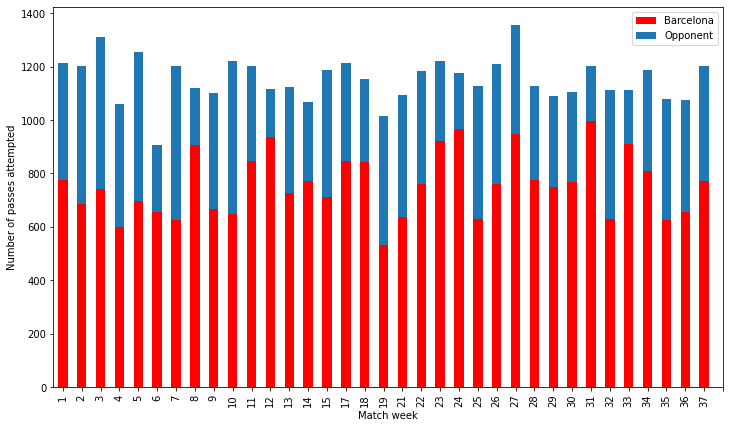

In [63]:
match_passes.query("possession_team == 'Barcelona'").match_week.value_counts().sort_index().plot.bar(figsize=(12,7), color = "red", label="Barcelona")
match_passes.query("possession_team != 'Barcelona'").match_week.value_counts().sort_index().plot.bar(figsize=(12,7), bottom = match_passes.query("possession_team == 'Barcelona'").match_week.value_counts().sort_index(), label="Opponent")
plt.xlabel("Match week")
plt.ylabel("Number of passes attempted")
plt.xticks(range(0,36))
plt.legend();

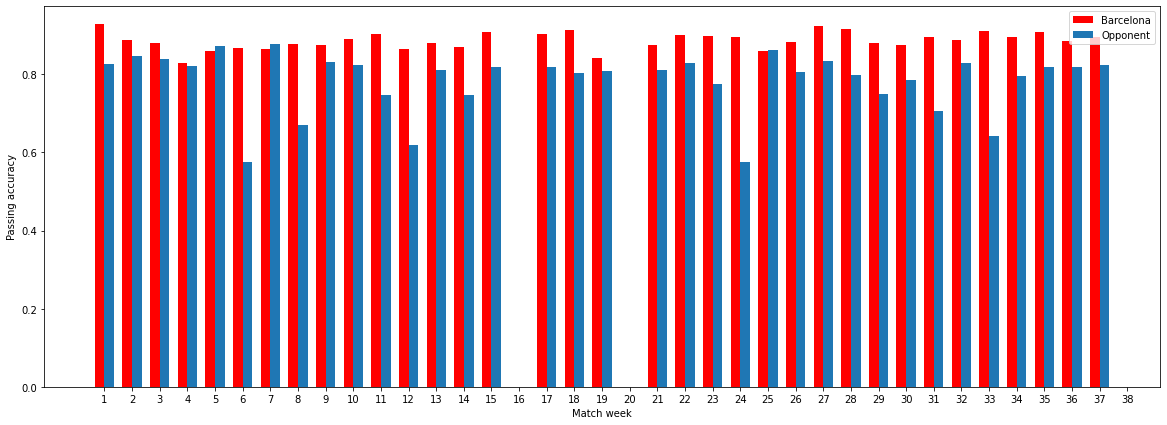

In [64]:
plt.figure(figsize=(20,7))
barcelona = match_passes.query("possession_team == 'Barcelona'").groupby("match_week").outcome.value_counts(normalize=True).loc[:,"Completed", :]
plt.bar(barcelona.index, barcelona.values, width=0.35, color="red", label ="Barcelona")

opponents = match_passes.query("possession_team != 'Barcelona'").groupby("match_week").outcome.value_counts(normalize=True).loc[:,"Completed", :]
opponents.index = (opponents.index + 0.35).astype(float)
plt.bar(opponents.index, opponents.values, width=0.35, label="Opponent")
plt.xticks([x+0.35/2 for x in range(1, 39)], range(1, 39));
plt.xlabel("Match week")
plt.ylabel("Passing accuracy")
plt.legend(loc="upper right");

In [65]:
match_passes.outcome.value_counts(normalize=True)

Completed           0.858839
Incomplete          0.122270
Out                 0.011652
Unknown             0.003967
Pass Offside        0.002826
Injury Clearance    0.000446
Name: outcome, dtype: float64

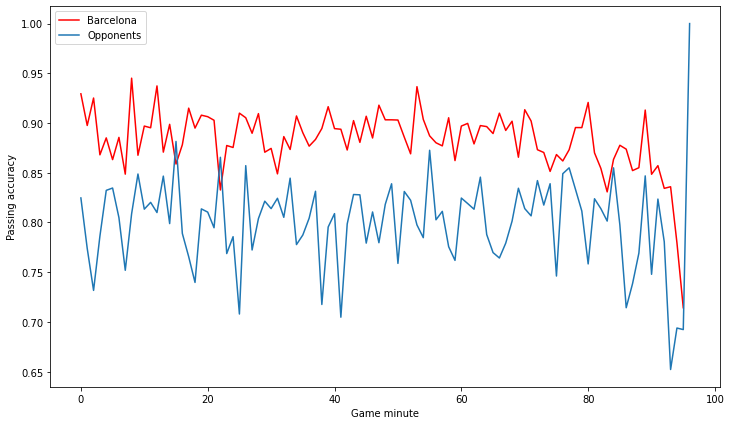

In [66]:
plt.figure(figsize=(12,7))
match_passes.query("possession_team == 'Barcelona'").groupby("minute")["outcome"].value_counts(normalize=True).loc[:,"Completed"].plot(color="red", label="Barcelona")
match_passes.query("possession_team != 'Barcelona'").groupby("minute")["outcome"].value_counts(normalize=True).loc[:,"Completed"].plot(label="Opponents")
plt.xlabel("Game minute")
plt.ylabel("Passing accuracy")
plt.legend();

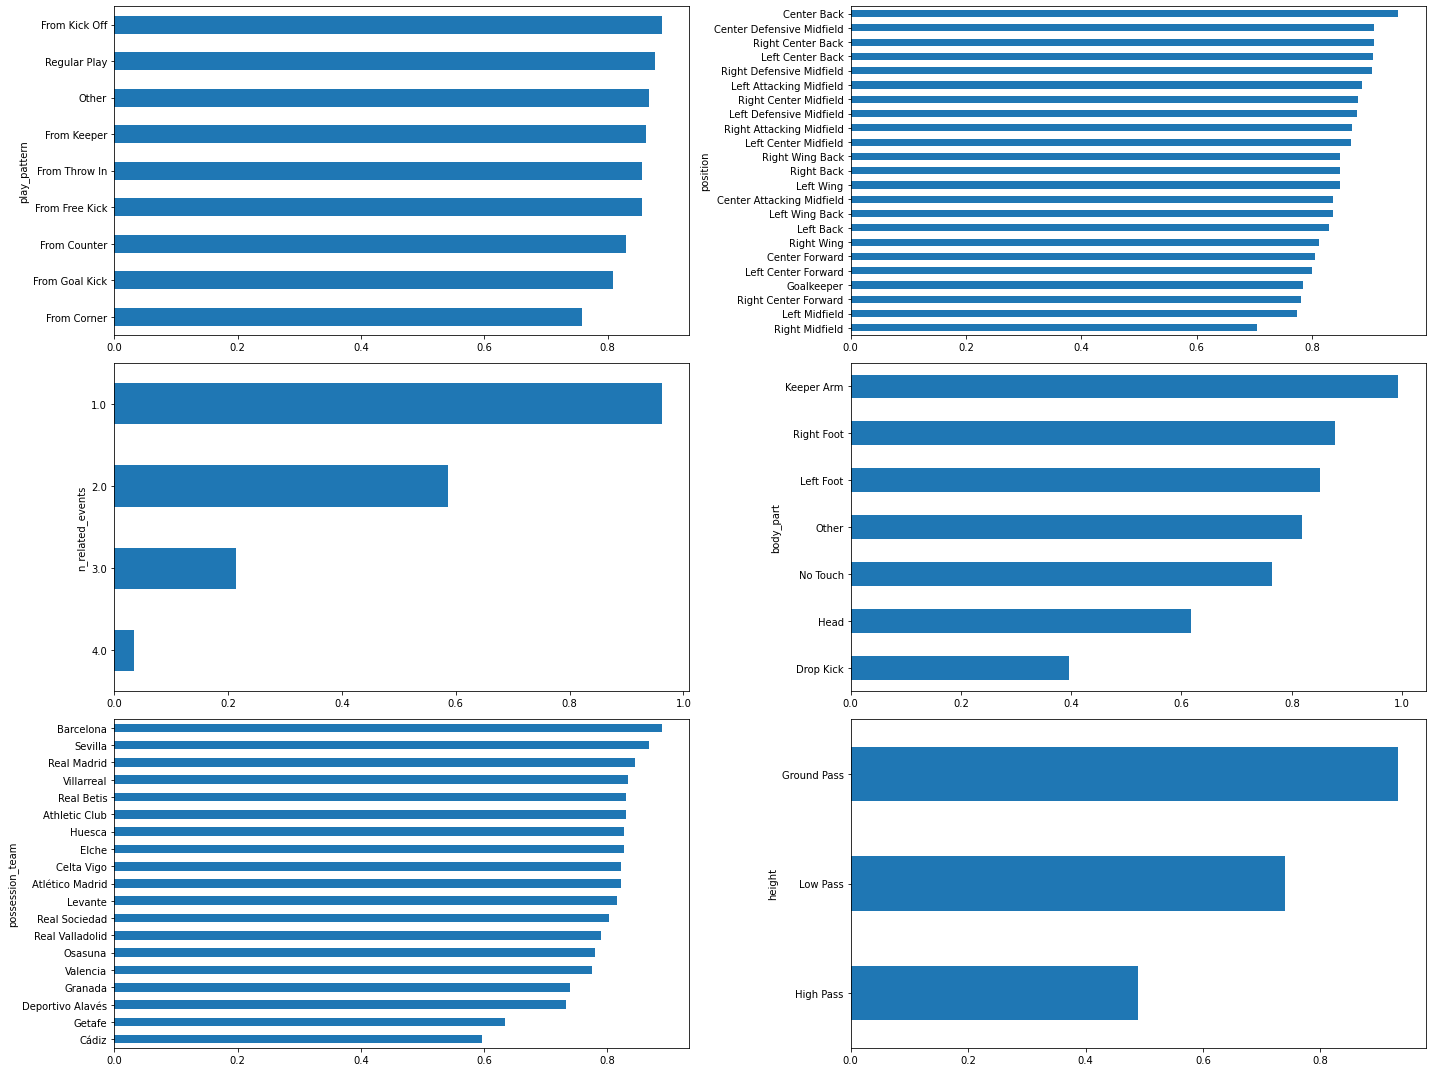

In [67]:
fig, axes = plt.subplots(3, 2, figsize=(20, 15))
for i, column in enumerate(["play_pattern", "position", "n_related_events", "body_part", "possession_team", "height"], 1):
    ax = plt.subplot(3, 2, i)
    match_passes.groupby(column)["outcome"].value_counts(normalize=True).loc[:,"Completed"].sort_values().plot.barh(ax=ax)

fig.tight_layout()

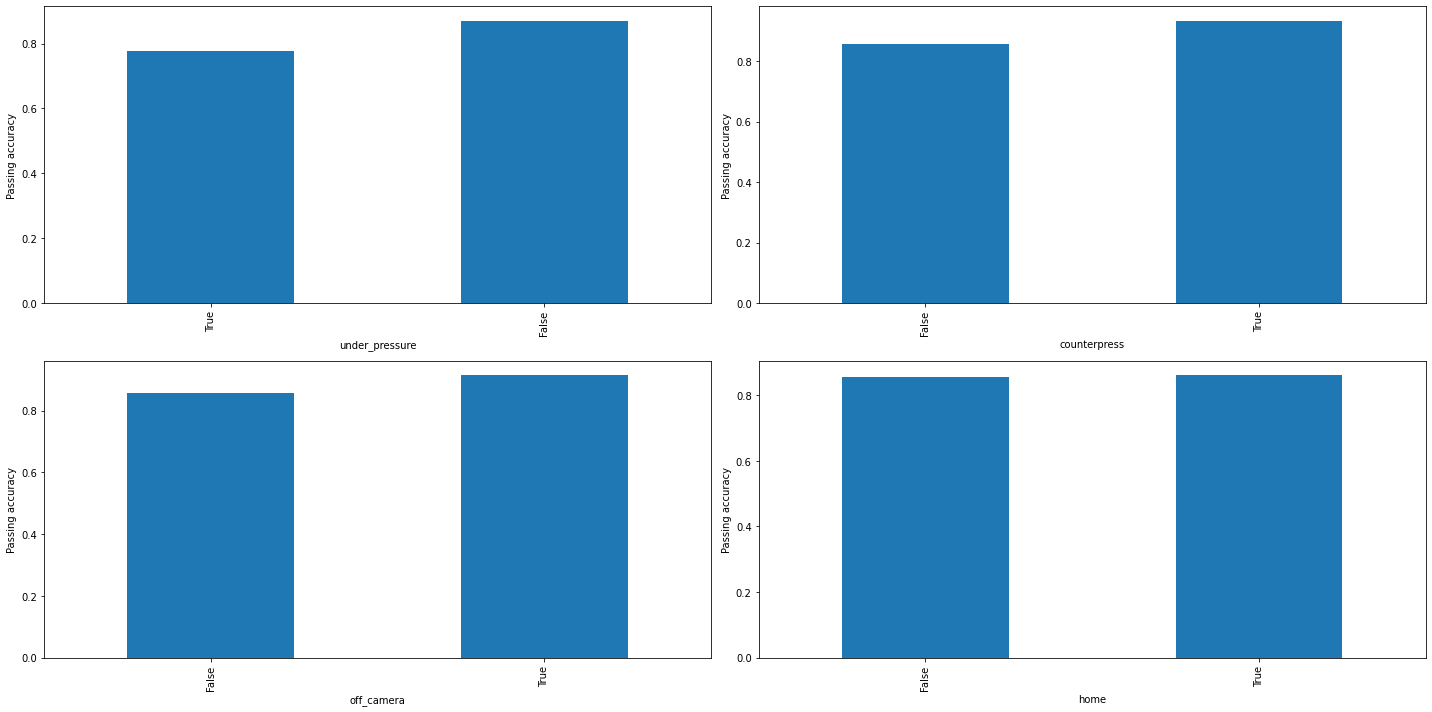

In [68]:
fig, axes = plt.subplots(2,2, figsize=(20, 10))

for i, column in enumerate(["under_pressure", "counterpress", "off_camera", "home"], 1):
    ax = plt.subplot(2, 2, i)
    match_passes.groupby(column)["outcome"].value_counts(normalize=True).loc[:,"Completed"].sort_values().plot.bar(ax=ax)
    ax.set_ylabel("Passing accuracy")

fig.tight_layout()

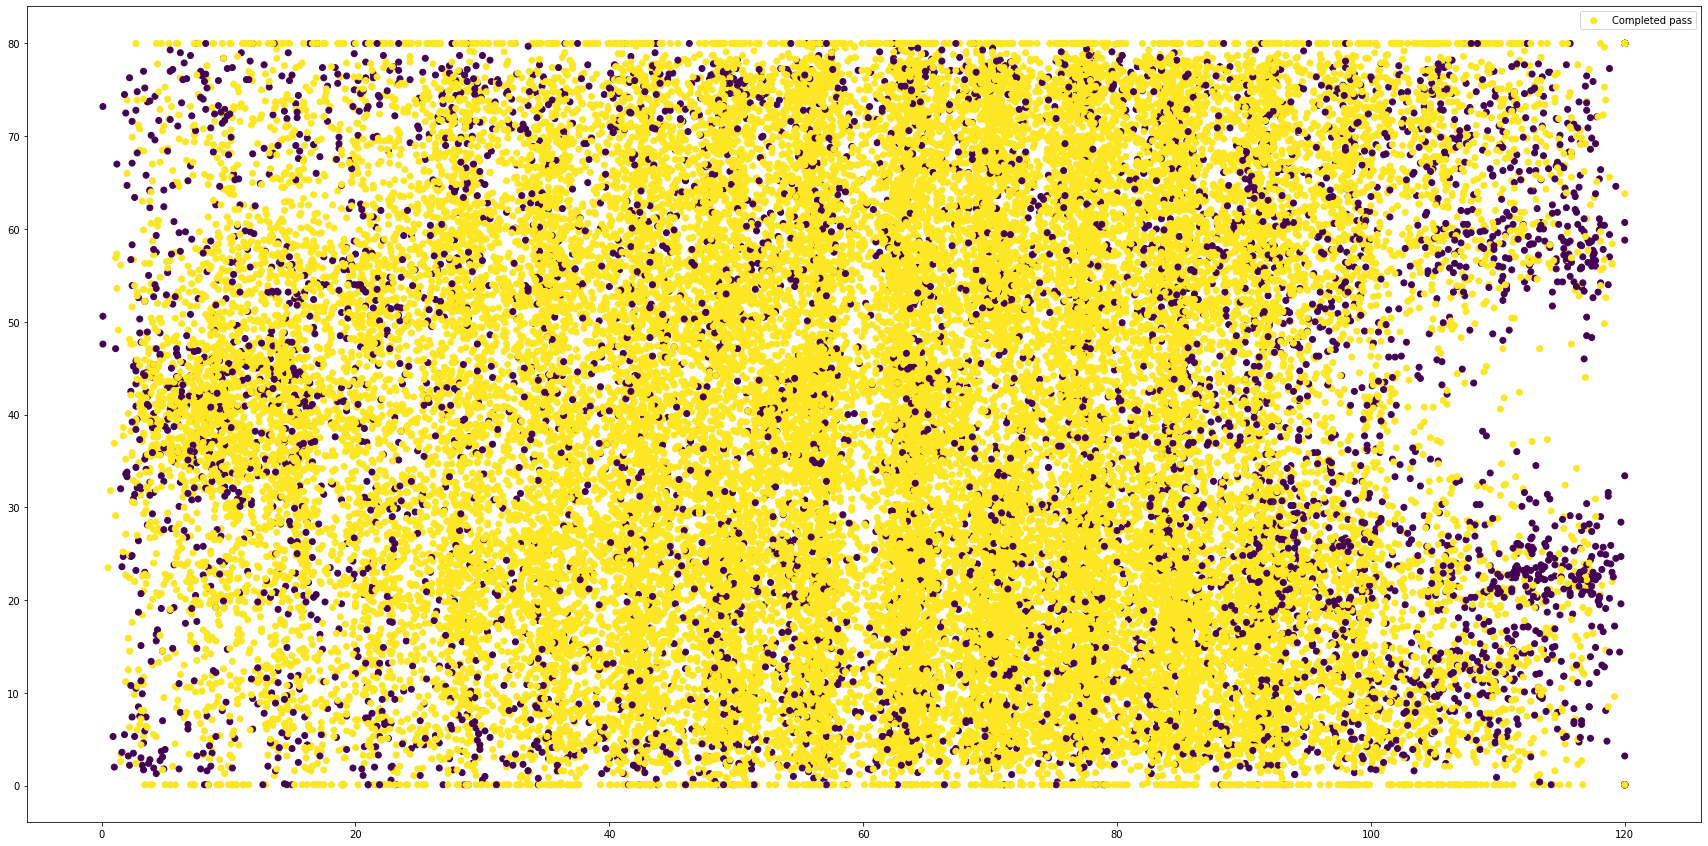

In [69]:
plt.figure(figsize=(30,15))
locations = match_passes["location"].apply(pd.Series)
locations.columns = ["x", "y"]
plt.scatter(locations["x"], locations["y"], c = match_passes["outcome"] == "Completed")
plt.legend({"Completed pass"});

In [70]:
match_passes.columns

Index(['id', 'index', 'period', 'timestamp', 'minute', 'second', 'type',
       'possession', 'possession_team', 'play_pattern', 'team', 'player',
       'position', 'location', 'duration', 'related_events', 'pass',
       'match_id', 'possession_team_id', 'player_id', 'under_pressure',
       'counterpress', 'off_camera', 'match_date', 'match_week', 'home_team',
       'away_team', 'out', 'outcome', 'recipient_id', 'length', 'angle',
       'height', 'body_part', 'end_location', 'home', 'opponent',
       'n_related_events'],
      dtype='object')

## Modeling

In [71]:
RANDOM_STATE = 42

In [72]:
TARGET = "outcome"
FEATURES = ["minute", "play_pattern", "location", "counterpress", "under_pressure", "off_camera", "match_week", "length", "angle", "height", "body_part", "end_location"]
CATEGORICAL_COLUMNS = ["play_pattern", "height", "body_part"]

In [73]:
def prepare_train_test_data(match_passes, features=FEATURES, categorical_columns=CATEGORICAL_COLUMNS, split=True):
    match_passes = match_passes.sort_values("match_week")
    X = match_passes[features].reset_index(drop=True)
    y = (match_passes[TARGET] == "Completed").astype(int).reset_index(drop=True)
    
    if "location" in features:
        X["location_x"], X["location_y"] = X["location"].apply(pd.Series).T.values
        X["end_location_x"], X["end_location_y"] = X["end_location"].apply(pd.Series).T.values
        X = X.drop(["location", "end_location"], axis=1)

    for c in ["counterpress", "under_pressure", "off_camera"]:
        if c not in X.columns: continue
        X[c] = X[c].astype(int)    
    
    encoder = OneHotEncoder()
    encoded_cat = pd.DataFrame(encoder.fit_transform(X[categorical_columns]).toarray(), columns = encoder.get_feature_names_out(input_features=categorical_columns)).astype(int)
    X = pd.concat([X, encoded_cat], axis=1).drop(categorical_columns, axis=1)
    
    if split:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False, random_state=RANDOM_STATE)
        return  X_train, X_test, y_train, y_test
    else: 
        return X, y



def build_and_evaluate_model(data, model_params):
    X_train, X_test, y_train, y_test = data
    model = xgb.XGBClassifier(**model_params)
    model.fit(X_train, y_train,
            eval_set = [(X_train, y_train), (X_test, y_test)],
            verbose=50
            )
    print("AUC score:", round(roc_auc_score(y_test, model.predict_proba(X_test)[:,1]), 3))
    print(confusion_matrix(y_test, model.predict(X_test)))
    return pd.DataFrame(model.feature_importances_, index=model.feature_names_in_, columns =["importance"]).sort_values("importance", ascending= False).T

In [74]:
scale_pos_weight = np.sqrt(match_passes["outcome"].value_counts().loc["Incomplete"]/match_passes["outcome"].value_counts().loc["Completed"])
model_params = {"n_estimators" : 700, "early_stopping_rounds":50, "learning_rate":0.05, "max_depth" : 5, "eval_metric":"auc", "scale_pos_weight":scale_pos_weight, "random_state": RANDOM_STATE}

In [75]:
X_train, X_test, y_train, y_test = prepare_train_test_data(match_passes=match_passes)
importances = build_and_evaluate_model((X_train, X_test, y_train, y_test), model_params)

[0]	validation_0-auc:0.85381	validation_1-auc:0.83507
[50]	validation_0-auc:0.91250	validation_1-auc:0.89949
[100]	validation_0-auc:0.92485	validation_1-auc:0.90818
[150]	validation_0-auc:0.93053	validation_1-auc:0.91102
[200]	validation_0-auc:0.93402	validation_1-auc:0.91227
[250]	validation_0-auc:0.93701	validation_1-auc:0.91194
[260]	validation_0-auc:0.93755	validation_1-auc:0.91209
AUC score: 0.912
[[ 363  180]
 [ 247 3244]]


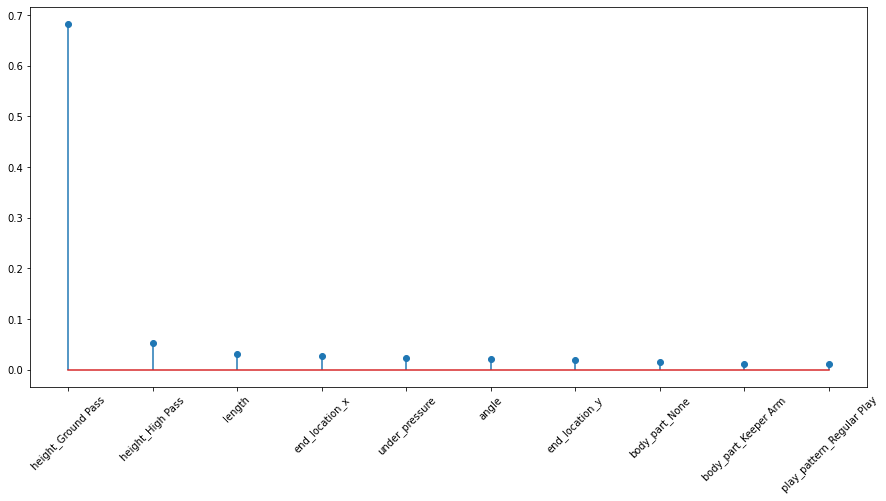

In [76]:
plt.figure(figsize=(15,7))
plt.stem(importances.T.index[:10], importances.T.values[:10])
plt.xticks(importances.T.index[:10], rotation=45);

### Pass accuracy feature

In [77]:
players_pass_accuracy = {}
for match_date in match_passes["match_date"].unique():
    df = match_passes[["match_date", "player_id", "outcome"]].query("match_date < @match_date")
    if len(df) == 0: continue
    pass_accuracy = df.sort_values("match_date").groupby("player_id").outcome.value_counts(normalize=True).loc[:, "Completed"]
    for player in pass_accuracy.to_dict():
        players_pass_accuracy[player] = players_pass_accuracy.get(player, {})
        players_pass_accuracy[player].update({match_date: pass_accuracy[player]})

In [78]:
match_passes["pass_accuracy"] = match_passes.apply(lambda x: players_pass_accuracy.get(x["player_id"], {}).get(x["match_date"]), axis = 1)

In [79]:
new_features_pa = FEATURES + ["pass_accuracy"]
X_train, X_test, y_train, y_test = prepare_train_test_data(match_passes=match_passes, features=new_features_pa)
build_and_evaluate_model((X_train, X_test, y_train, y_test), model_params)

[0]	validation_0-auc:0.85389	validation_1-auc:0.83520
[50]	validation_0-auc:0.91600	validation_1-auc:0.90223
[100]	validation_0-auc:0.92860	validation_1-auc:0.91002
[150]	validation_0-auc:0.93385	validation_1-auc:0.91371
[200]	validation_0-auc:0.93769	validation_1-auc:0.91412
[232]	validation_0-auc:0.93950	validation_1-auc:0.91419
AUC score: 0.914
[[ 370  173]
 [ 262 3229]]


,height_Ground Pass,height_High Pass,length,end_location_x,angle,under_pressure,end_location_y,body_part_None,body_part_Keeper Arm,pass_accuracy,body_part_Head,play_pattern_Regular Play,location_y,play_pattern_From Throw In,location_x,body_part_Right Foot,play_pattern_From Corner,off_camera,counterpress,body_part_Left Foot,play_pattern_From Goal Kick,play_pattern_From Counter,play_pattern_From Keeper,body_part_No Touch,play_pattern_From Free Kick,match_week,body_part_Other,minute,height_Low Pass,play_pattern_From Kick Off,body_part_Drop Kick,play_pattern_Other
importance,0.589976,0.090636,0.03515,0.034548,0.025895,0.025851,0.020819,0.016763,0.013286,0.012524,0.011747,0.011475,0.010887,0.010722,0.010249,0.00768,0.007072,0.006894,0.006784,0.006275,0.00614,0.006132,0.005849,0.005405,0.005207,0.004125,0.003503,0.003377,0.003063,0.001963,0.0,0.0


### Pass accuracy last n games

In [80]:
N = 5

players_pass_accuracy_last_n = {}
for match_date in match_passes["match_date"].unique():
    df = match_passes[["match_date", "player_id", "outcome"]].query("match_date < @match_date")
    df["match_rank"] = df["match_date"].rank(method="dense")
    df["match_rank"] = df["match_rank"].max() - df["match_rank"] + 1
    df = df.query("match_rank <= @N")
    if len(df) == 0: continue
    pass_accuracy = df.sort_values("match_date").groupby("player_id").outcome.value_counts(normalize=True).loc[:, "Completed"]
    for player in pass_accuracy.to_dict():
        players_pass_accuracy_last_n[player] = players_pass_accuracy_last_n.get(player, {})
        players_pass_accuracy_last_n[player].update({match_date: pass_accuracy[player]})

In [81]:
match_passes["pass_accuracy_last_5"] = match_passes.apply(lambda x: players_pass_accuracy_last_n.get(x["player_id"], {}).get(x["match_date"]), axis = 1)

In [82]:
new_features_pa5 = FEATURES + ["pass_accuracy_last_5"]
X_train, X_test, y_train, y_test = prepare_train_test_data(match_passes=match_passes, features=new_features_pa5, categorical_columns=CATEGORICAL_COLUMNS)
build_and_evaluate_model((X_train, X_test, y_train, y_test), model_params)

[0]	validation_0-auc:0.85393	validation_1-auc:0.83497
[50]	validation_0-auc:0.91496	validation_1-auc:0.90172
[100]	validation_0-auc:0.92796	validation_1-auc:0.91028
[150]	validation_0-auc:0.93342	validation_1-auc:0.91267
[200]	validation_0-auc:0.93697	validation_1-auc:0.91359
[250]	validation_0-auc:0.94033	validation_1-auc:0.91421
[300]	validation_0-auc:0.94345	validation_1-auc:0.91464
[350]	validation_0-auc:0.94622	validation_1-auc:0.91472
[400]	validation_0-auc:0.94876	validation_1-auc:0.91469
[404]	validation_0-auc:0.94892	validation_1-auc:0.91465
AUC score: 0.915
[[ 381  162]
 [ 257 3234]]


,height_Ground Pass,height_High Pass,length,end_location_x,under_pressure,angle,body_part_None,end_location_y,body_part_Keeper Arm,play_pattern_Regular Play,pass_accuracy_last_5,body_part_Head,play_pattern_From Throw In,location_y,location_x,play_pattern_From Corner,body_part_Other,counterpress,off_camera,body_part_Right Foot,play_pattern_From Goal Kick,body_part_Left Foot,body_part_No Touch,play_pattern_From Free Kick,play_pattern_From Kick Off,play_pattern_From Keeper,match_week,play_pattern_From Counter,minute,height_Low Pass,body_part_Drop Kick,play_pattern_Other
importance,0.647034,0.054995,0.028163,0.027292,0.025886,0.022521,0.019718,0.018786,0.013047,0.012102,0.011303,0.010648,0.009289,0.009146,0.008517,0.00792,0.007326,0.007313,0.006322,0.006068,0.005869,0.0054,0.005021,0.004914,0.004415,0.004411,0.004211,0.003896,0.003751,0.002798,0.001919,0.0


### Match pass accuracy feature

In [83]:
match_passes["completed"] = match_passes["outcome"] == "Completed"
index = match_passes.groupby(["player_id", "match_week", "minute"]).agg({"completed": ["sum", "count"]}).index
passes_completed = (match_passes.groupby(["player_id", "match_week", "minute"]).agg({"completed": ["sum", "count"]})).reset_index()["completed"].set_index(index).groupby(["player_id", "match_week"]).cumsum()

In [84]:
match_pass_accuracy = pd.DataFrame((passes_completed["sum"]/passes_completed["count"]).shift(1).rename("match_pass_accuracy"))
match_passes = match_passes.merge(match_pass_accuracy, right_index=True, left_on=["player_id", "match_week", "minute"])

In [85]:
new_features_mpa = new_features_pa + ["match_pass_accuracy"]
X_train, X_test, y_train, y_test = prepare_train_test_data(match_passes=match_passes, features=new_features_mpa)
build_and_evaluate_model((X_train, X_test, y_train, y_test), model_params)

[0]	validation_0-auc:0.85392	validation_1-auc:0.83491
[50]	validation_0-auc:0.91641	validation_1-auc:0.90101
[100]	validation_0-auc:0.92921	validation_1-auc:0.90993
[150]	validation_0-auc:0.93454	validation_1-auc:0.91360
[200]	validation_0-auc:0.93843	validation_1-auc:0.91480
[250]	validation_0-auc:0.94153	validation_1-auc:0.91476
[265]	validation_0-auc:0.94238	validation_1-auc:0.91487
AUC score: 0.915
[[ 374  169]
 [ 255 3236]]


,height_Ground Pass,height_High Pass,end_location_x,length,under_pressure,angle,end_location_y,body_part_None,play_pattern_Regular Play,body_part_Keeper Arm,pass_accuracy,body_part_Head,location_y,play_pattern_From Throw In,location_x,play_pattern_From Corner,match_pass_accuracy,counterpress,body_part_Left Foot,play_pattern_From Goal Kick,play_pattern_From Free Kick,play_pattern_From Counter,off_camera,body_part_Right Foot,body_part_No Touch,match_week,body_part_Other,minute,play_pattern_From Kick Off,height_Low Pass,body_part_Drop Kick,play_pattern_From Keeper,play_pattern_Other
importance,0.618528,0.066834,0.032815,0.032762,0.026954,0.025372,0.019797,0.015143,0.012996,0.012263,0.012144,0.012011,0.010744,0.010614,0.00996,0.008018,0.007521,0.006679,0.006516,0.005726,0.005564,0.005501,0.00529,0.005211,0.004486,0.004241,0.004128,0.003078,0.002924,0.002816,0.002813,0.000551,0.0


<AxesSubplot:>

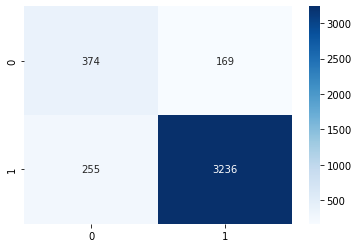

In [86]:
import seaborn as sns
sns.heatmap([[ 374,  169],
            [255, 3236]], cmap="Blues",annot =True, fmt=".0f")

### Running model only on ground passes

In [87]:
match_ground_passes = match_passes.query("height == 'Ground Pass'")
new_features_ground = list(set(new_features_pa) - set(["height"]))
cat_cols_ground = list(set(CATEGORICAL_COLUMNS) - set(["height"]))
X_train, X_test, y_train, y_test = prepare_train_test_data(match_passes=match_ground_passes, features=new_features_ground, categorical_columns=cat_cols_ground)
model_params["scale_pos_weight"] = np.sqrt((1-y_train).sum()/y_train.sum()) #Updating scale_pos_weight as the target variable distribution changed
build_and_evaluate_model((X_train, X_test, y_train, y_test), model_params)

[0]	validation_0-auc:0.79657	validation_1-auc:0.76484
[50]	validation_0-auc:0.90236	validation_1-auc:0.86756
[100]	validation_0-auc:0.91958	validation_1-auc:0.87293
[150]	validation_0-auc:0.92860	validation_1-auc:0.87402
[200]	validation_0-auc:0.93559	validation_1-auc:0.87409
[250]	validation_0-auc:0.94204	validation_1-auc:0.87415
[272]	validation_0-auc:0.94474	validation_1-auc:0.87334
AUC score: 0.875
[[  90  108]
 [  94 2840]]


,length,end_location_x,under_pressure,end_location_y,angle,off_camera,pass_accuracy,play_pattern_From Corner,location_x,location_y,body_part_Right Foot,play_pattern_From Goal Kick,body_part_No Touch,play_pattern_Regular Play,body_part_Left Foot,minute,play_pattern_From Free Kick,play_pattern_From Throw In,match_week,body_part_Keeper Arm,play_pattern_From Counter,play_pattern_From Kick Off,play_pattern_From Keeper,play_pattern_Other,counterpress,body_part_Other
importance,0.150581,0.126537,0.100753,0.076533,0.070209,0.049188,0.045997,0.040658,0.038255,0.03379,0.032608,0.02647,0.026173,0.02605,0.024371,0.021628,0.021173,0.02053,0.020136,0.0192,0.016535,0.012623,0.0,0.0,0.0,0.0


### SHAP Values

In [88]:
model_params = {"n_estimators" : 700, "learning_rate":0.05, "max_depth" : 5, "eval_metric":"auc", "scale_pos_weight":scale_pos_weight, "random_state": RANDOM_STATE}

In [89]:
X_train, X_test, y_train, y_test = prepare_train_test_data(match_passes=match_passes, features=new_features_mpa)
model = xgb.XGBClassifier(**model_params)
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.05, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=700, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=42, ...)

In [90]:
shap_values = shap.TreeExplainer(model).shap_values(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


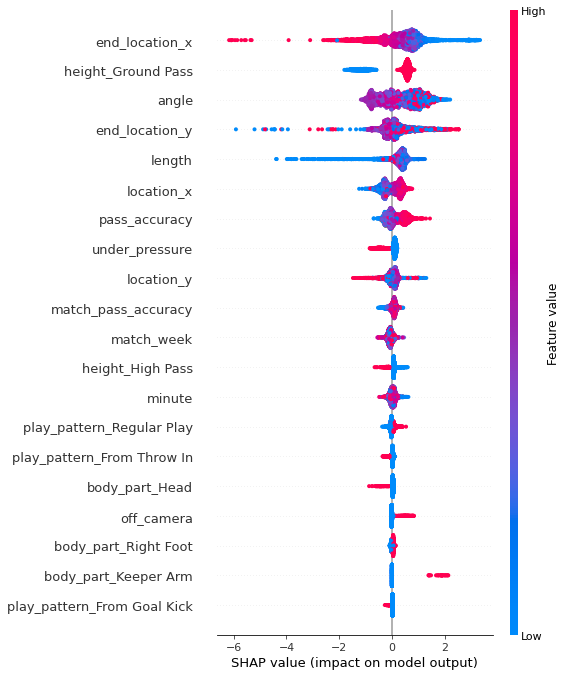

In [91]:
shap.summary_plot(shap_values, X_test)

### Testing model on different competition data

In [92]:
CHAMPIONS_LEAGUE_ID = 16
SEASON_1819_ID = 4

In [93]:
TARGET = "outcome"
FEATURES = ["minute", "play_pattern", "location", "under_pressure", "off_camera", "match_week", "length", "angle", "height", "body_part", "end_location"]
CATEGORICAL_COLUMNS = ["play_pattern", "height", "body_part"]

In [94]:
all_matches_test = sb.matches(competition_id=CHAMPIONS_LEAGUE_ID, season_id=SEASON_1819_ID)
match_passes_test = pd.concat(
               [sb.events(match_id=match_id, split=True, flatten_attrs=False)["passes"]
               .assign(match_date = match_date)
               .assign(match_week = match_week) 
               .assign(home_team = home_team)
               .assign(away_team = away_team)
               for match_id, match_week, home_team, away_team, match_date 
               in zip(
                    all_matches_test["match_id"], all_matches_test["match_week"],
                    all_matches_test["home_team"], all_matches_test["away_team"],
                    all_matches_test["match_date"]
                     )
                ]
               )

credentials were not supplied. open data access only
credentials were not supplied. open data access only


In [95]:
match_passes_test = extract_pass_features(match_passes_test)
match_passes_test = manage_nas(match_passes_test)

In [96]:
X_train, y_train = prepare_train_test_data(match_passes=match_passes, features=FEATURES, split=False)
X_test, y_test = prepare_train_test_data(match_passes=match_passes_test, features=FEATURES, split=False)

In [97]:
common_features = list(set(X_train.columns).intersection(set(X_test.columns)))

X_train = X_train[common_features]
X_test = X_test[common_features]

In [98]:
model_params = {"n_estimators" : 700, "learning_rate":0.05, "max_depth" : 5, "eval_metric":"auc", "scale_pos_weight":scale_pos_weight, "random_state": RANDOM_STATE}

In [99]:
model = xgb.XGBClassifier(**model_params)
model.fit(X_train, y_train)
print("AUC score:", round(roc_auc_score(y_test, model.predict_proba(X_test)[:,1]), 3))
print(confusion_matrix(y_test, model.predict(X_test)))

AUC score: 0.924
[[206  35]
 [ 89 560]]


In [100]:
pd.DataFrame(model.feature_importances_, index=model.feature_names_in_).sort_values(0, ascending=False).head(10)

,0
height_Ground Pass,0.628806
height_High Pass,0.058558
under_pressure,0.030463
length,0.027741
end_location_x,0.027585
body_part_None,0.023540
angle,0.022570
end_location_y,0.020609
body_part_Keeper Arm,0.017033
body_part_Head,0.013932


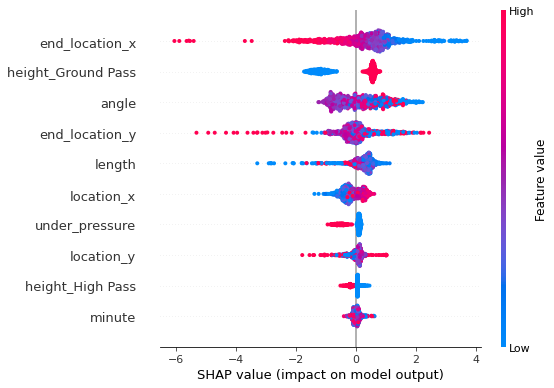

In [112]:
shap_values = shap.TreeExplainer(model).shap_values(X_test)
shap.summary_plot(shap_values, X_test, max_display=10)